In [26]:
from ultralytics import YOLO
import io
from PIL import Image
import urllib.request
import cv2
import numpy as np
from paddleocr import PaddleOCR
import re
import os
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [27]:
# Download latest version
path = kagglehub.dataset_download("unidpro/spain-license-plate-dataset")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\alvar\.cache\kagglehub\datasets\unidpro\spain-license-plate-dataset\versions\1


In [28]:
# Initialize YOLO model for license plate detection
model = YOLO("../models/best.pt")

# Initialize PaddleOCR (will be used later)
ocr = PaddleOCR(use_angle_cls=True, lang="en")

print(f"✅ YOLO model loaded: {model}")
print(f"✅ PaddleOCR initialized")

[2025/12/13 18:01:49] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\alvar/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\alvar/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320',

✅ YOLO model loaded: YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affi

In [29]:
def extract_license_plate(ocr_result, confidence_threshold=0.7):
    """
    Extracts and cleans the text OCR with highest confidence.
    """
    if not ocr_result or not ocr_result[0]:
        return "No plate detected", 0.0

    best_text = ""
    max_confidence = 0

    for detection in ocr_result[0]:
        text = detection[1][0]
        confidence = detection[1][1]

        if confidence > confidence_threshold and confidence > max_confidence:
            best_text = text
            max_confidence = confidence

    cleaned_text = re.sub(r'[^A-Za-z0-9]', '', best_text).upper()
    return cleaned_text if cleaned_text else "No plate detected", max_confidence


In [30]:
# Load test images from the dataset
dataset_path = Path(path)
test_images_path = dataset_path

# Get list of test images
test_image_files = list(test_images_path.glob("*.jpg")) + list(test_images_path.glob("*.png"))
print(f"Found {len(test_image_files)} test images")

# Load a sample of images for testing
num_samples = min(20, len(test_image_files))
sample_images = []
sample_paths = []

for img_path in test_image_files[:num_samples]:
    img = cv2.imread(str(img_path))
    if img is not None:
        # Convert BGR to RGB for display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sample_images.append(img_rgb)
        sample_paths.append(img_path)

print(f"✅ Loaded {len(sample_images)} sample images")
print(f"Image shapes: {[img.shape for img in sample_images[:3]]}")

Found 10 test images
✅ Loaded 10 sample images
Image shapes: [(760, 1440, 3), (760, 1440, 3), (760, 1440, 3)]


In [31]:
# Test YOLO detection on clean images
print("="*70)
print("TESTING YOLO DETECTION ON CLEAN IMAGES")
print("="*70)

detection_results = []

for idx, img in enumerate(sample_images[:5]):
    # Convert RGB to BGR for YOLO
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Run YOLO detection
    results = model.predict(source=img_bgr, save=False, verbose=False)
    
    if results and len(results) > 0 and len(results[0].boxes.data) > 0:
        detections = results[0].boxes.data
        num_detections = len(detections)
        
        # Get first detection
        if num_detections > 0:
            x1, y1, x2, y2, conf, cls = detections[0][:6]
            detection_results.append({
                'idx': idx,
                'detected': True,
                'confidence': float(conf),
                'bbox': [int(x1), int(y1), int(x2), int(y2)],
                'class': int(cls)
            })
            print(f"Image {idx}: Detected (conf={conf:.3f}), bbox=[{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}]")
    else:
        detection_results.append({
            'idx': idx,
            'detected': False,
            'confidence': 0.0,
            'bbox': None,
            'class': None
        })
        print(f"Image {idx}: ❌ No detection")

print(f"\nDetection success rate: {sum(1 for r in detection_results if r['detected'])}/{len(detection_results)}")

TESTING YOLO DETECTION ON CLEAN IMAGES
Image 0: Detected (conf=0.662), bbox=[587, 541, 848, 605]
Image 1: Detected (conf=0.730), bbox=[640, 578, 884, 645]
Image 2: Detected (conf=0.736), bbox=[604, 545, 850, 608]
Image 3: Detected (conf=0.728), bbox=[630, 566, 854, 621]
Image 4: Detected (conf=0.631), bbox=[1320, 475, 1440, 527]

Detection success rate: 5/5


In [32]:
# Quick OCR test on first detected plate (using extract_license_plate)
print("="*70)
print("TESTING OCR ON DETECTED PLATE")
print("="*70)

# Use first available test image
if 'test_image_files' in globals() and len(test_image_files) > 0:
    img_path = test_image_files[0]
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"Failed to read image: {img_path}")
    else:
        # Detect plate with YOLO
        results = model.predict(source=img_bgr, save=False, verbose=False)
        if results and len(results) > 0 and len(results[0].boxes.data) > 0:
            x1, y1, x2, y2, conf, cls = results[0].boxes.data[0][:6]
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            print(f"Detected bbox: [{x1}, {y1}, {x2}, {y2}] (conf={float(conf):.3f})")
            
            # Crop ROI and run OCR (expects RGB)
            plate_bgr = img_bgr[y1:y2, x1:x2]
            if plate_bgr.size == 0:
                print("Invalid ROI for OCR")
            else:
                plate_rgb = cv2.cvtColor(plate_bgr, cv2.COLOR_BGR2RGB)
                ocr_result = ocr.ocr(plate_rgb)
                # Use the proven helper if available; else parse best text
                try:
                    cleaned_text, best_conf = extract_license_plate(ocr_result)
                except Exception:
                    best_text = ""; best_conf = 0.0
                    if ocr_result and len(ocr_result) > 0 and isinstance(ocr_result[0], list):
                        for det in ocr_result[0]:
                            if isinstance(det, (list, tuple)) and len(det) >= 2:
                                info = det[1]
                                if isinstance(info, (list, tuple)) and len(info) >= 2:
                                    txt, cf = info[0], float(info[1])
                                    if cf > best_conf and isinstance(txt, str):
                                        best_text, best_conf = txt, cf
                    cleaned_text = re.sub(r'[^A-Za-z0-9]', '', best_text).upper()
                print(f"OCR Text: '{cleaned_text}' (conf={best_conf:.2f})")
        else:
            print("No plate detected in the selected image.")
else:
    print("No test images available. Run the dataset download cell first.")

TESTING OCR ON DETECTED PLATE
Detected bbox: [587, 541, 848, 605] (conf=0.662)
[2025/12/13 18:01:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.020429134368896484
[2025/12/13 18:01:51] ppocr DEBUG: cls num  : 1, elapsed : 0.011001348495483398
[2025/12/13 18:01:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07066941261291504
OCR Text: '9462KFW' (conf=0.93)


## ATTACK 1: DETECTION DoS

FGSM (Fast Gradient Sign Method) attack will be used to create adversarial examples that:
- **Fool the YOLO detector** to either miss the license plate or reduce detection confidence
- Use **gradient-based perturbations** to modify input images
- Test the **robustness** of the license plate detection system

We'll implement two attack strategies:
1. **Untargeted Attack**: Make YOLO fail to detect the license plate
2. **Confidence Reduction**: Lower the detection confidence below a threshold

In [33]:
# Simplified FGSM attack using direct pixel perturbation
def fgsm_attack_simple(model, image, epsilon, targeted_region=None):
    """
    Simplified FGSM-style attack: add noise to reduce YOLO detection.
    
    Args:
        model: YOLO model
        image: RGB image (numpy array)
        epsilon: Perturbation magnitude (0-255 scale)
        targeted_region: If provided, only perturb this region [x1, y1, x2, y2]
    
    Returns:
        Adversarial image (numpy array)
    """
    adv_image = image.copy().astype(np.float32)
    
    # Create perturbation
    perturbation = np.random.uniform(-epsilon, epsilon, image.shape).astype(np.float32)
    
    # If targeted region specified, zero out perturbation elsewhere
    if targeted_region is not None:
        x1, y1, x2, y2 = targeted_region
        mask = np.zeros_like(adv_image)
        mask[y1:y2, x1:x2] = 1
        perturbation = perturbation * mask
    
    # Add perturbation
    adv_image = adv_image + perturbation
    adv_image = np.clip(adv_image, 0, 255).astype(np.uint8)
    
    return adv_image

print("FGSM like attack function defined")

FGSM like attack function defined


In [34]:
# Run FGSM attacks on detected license plates
print("="*70)
print("RUNNING FGSM ATTACKS ON YOLO DETECTION")
print("="*70)

epsilon_values = [5, 10, 15, 20, 25, 30, 40, 50]
attack_results = []

# Select images where detection was successful
successful_detections = [r for r in detection_results if r['detected']]
print(f"Testing on {len(successful_detections)} successfully detected images\n")

for det in successful_detections[:5]:  # Test on first 5 successful detections
    idx = det['idx']
    original_img = sample_images[idx]
    bbox = det['bbox']
    original_conf = det['confidence']
    
    print(f"\n{'='*50}")
    print(f"Image {idx}: Original confidence = {original_conf:.3f}")
    print(f"Bounding box: {bbox}")
    
    # Try different epsilon values
    for eps in epsilon_values:
        # Create adversarial example (targeted attack on license plate region)
        adv_img = fgsm_attack_simple(model, original_img, epsilon=eps, targeted_region=bbox)
        
        # Test detection on adversarial image
        adv_img_bgr = cv2.cvtColor(adv_img, cv2.COLOR_RGB2BGR)
        results = model.predict(source=adv_img_bgr, save=False, verbose=False)
        
        if results and len(results) > 0 and len(results[0].boxes.data) > 0:
            adv_conf = float(results[0].boxes.data[0][4])
            detected = True
            conf_drop = original_conf - adv_conf
        else:
            adv_conf = 0.0
            detected = False
            conf_drop = original_conf
        
        print(f"  ε={eps:3d}: conf={adv_conf:.3f}, drop={conf_drop:.3f}, detected={detected}")
        
        # Store result
        attack_results.append({
            'image_idx': idx,
            'epsilon': eps,
            'original_conf': original_conf,
            'adv_conf': adv_conf,
            'conf_drop': conf_drop,
            'detected': detected,
            'attack_success': not detected or adv_conf < 0.5,
            'bbox': bbox
        })
        
        # If detection fails, record and move to next image
        if not detected:
            print(f"  Attack succeeded! Detection failed at ε={eps}")
            break

print("\n" + "="*70)
print("ATTACK SUMMARY")
print("="*70)
successful_attacks = sum(1 for r in attack_results if r['attack_success'])
print(f"Total attacks attempted: {len(attack_results)}")
print(f"Successful attacks (conf < 0.5 or no detection): {successful_attacks}")
print(f"Success rate: {successful_attacks/len(attack_results)*100:.1f}%")
print("="*70)

RUNNING FGSM ATTACKS ON YOLO DETECTION
Testing on 5 successfully detected images


Image 0: Original confidence = 0.662
Bounding box: [587, 541, 848, 605]
  ε=  5: conf=0.660, drop=0.002, detected=True
  ε= 10: conf=0.676, drop=-0.015, detected=True
  ε= 15: conf=0.666, drop=-0.005, detected=True
  ε= 20: conf=0.668, drop=-0.006, detected=True
  ε= 25: conf=0.634, drop=0.028, detected=True
  ε= 30: conf=0.558, drop=0.104, detected=True
  ε= 40: conf=0.000, drop=0.662, detected=False
  Attack succeeded! Detection failed at ε=40

Image 1: Original confidence = 0.730
Bounding box: [640, 578, 884, 645]
  ε=  5: conf=0.728, drop=0.002, detected=True
  ε= 10: conf=0.724, drop=0.007, detected=True
  ε= 15: conf=0.716, drop=0.014, detected=True
  ε= 20: conf=0.695, drop=0.035, detected=True
  ε= 25: conf=0.653, drop=0.077, detected=True
  ε= 30: conf=0.610, drop=0.120, detected=True
  ε= 40: conf=0.262, drop=0.468, detected=True
  ε= 50: conf=0.000, drop=0.730, detected=False
  Attack succeede


VISUALIZING ADVERSARIAL EXAMPLES


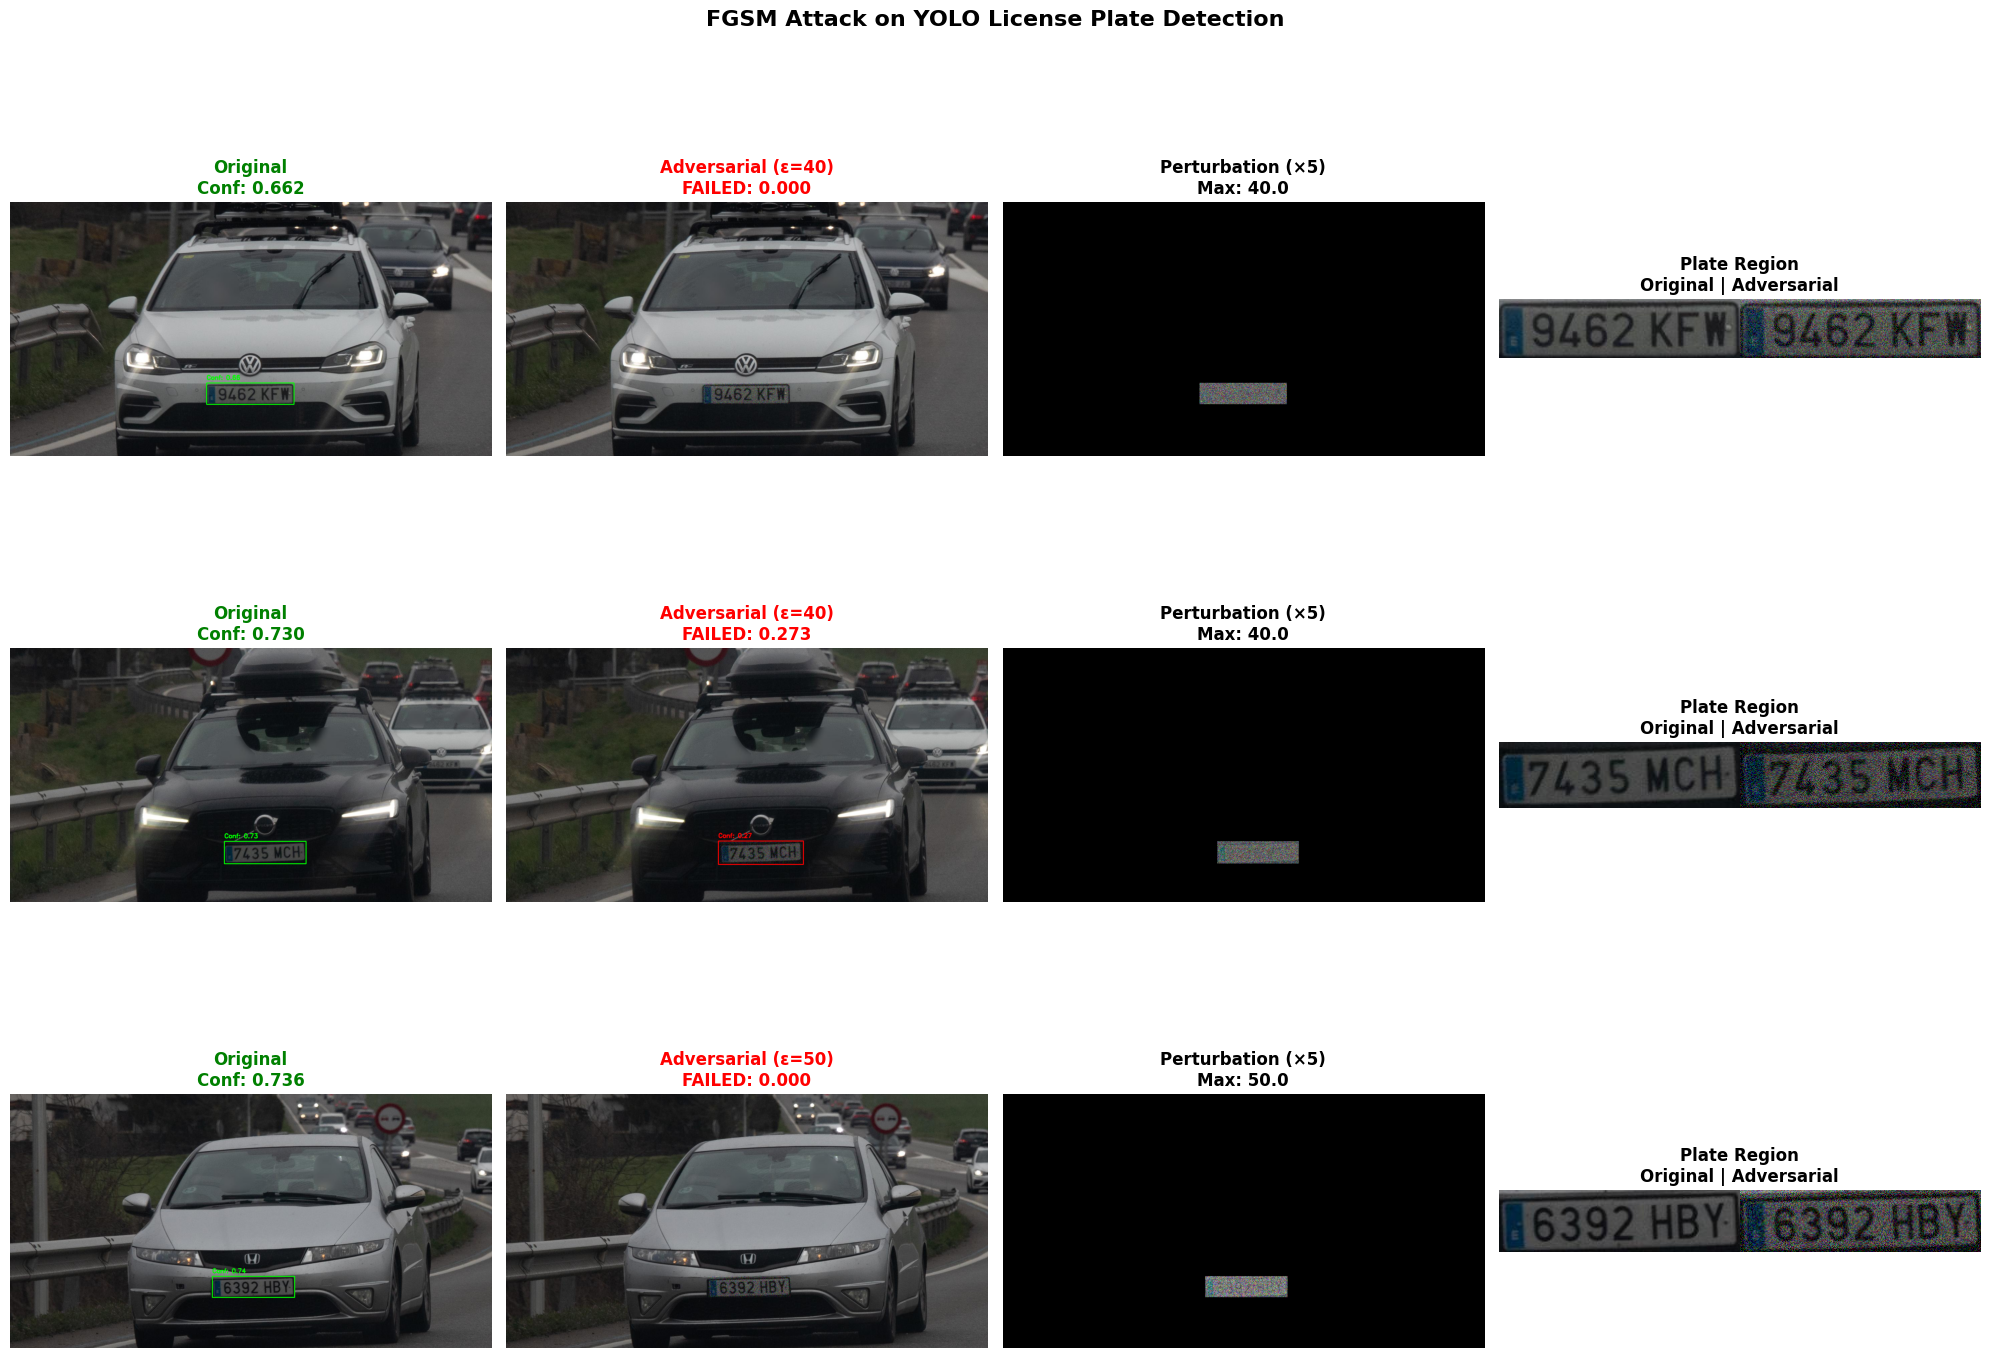

In [35]:
# Visualize adversarial examples
print("\n" + "="*70)
print("VISUALIZING ADVERSARIAL EXAMPLES")
print("="*70)

# Group results by image
images_to_visualize = {}
for r in attack_results:
    img_idx = r['image_idx']
    if img_idx not in images_to_visualize:
        images_to_visualize[img_idx] = []
    images_to_visualize[img_idx].append(r)

# Select images to display (first 3)
num_display = min(3, len(images_to_visualize))
display_images = list(images_to_visualize.keys())[:num_display]

fig, axes = plt.subplots(num_display, 4, figsize=(20, 5 * num_display))
if num_display == 1:
    axes = axes.reshape(1, -1)

for row_idx, img_idx in enumerate(display_images):
    original_img = sample_images[img_idx]
    results_for_img = images_to_visualize[img_idx]
    
    # Find first successful attack
    successful_attack = next((r for r in results_for_img if r['attack_success']), results_for_img[-1])
    
    epsilon_used = successful_attack['epsilon']
    bbox = successful_attack['bbox']
    x1, y1, x2, y2 = bbox
    
    # Create adversarial image with same epsilon
    adv_img = fgsm_attack_simple(model, original_img, epsilon=epsilon_used, targeted_region=bbox)
    
    # Calculate perturbation
    perturbation = adv_img.astype(np.float32) - original_img.astype(np.float32)
    perturbation_abs = np.abs(perturbation)
    
    # Get detection results
    orig_img_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
    adv_img_bgr = cv2.cvtColor(adv_img, cv2.COLOR_RGB2BGR)
    
    orig_results = model.predict(source=orig_img_bgr, save=False, verbose=False)
    adv_results = model.predict(source=adv_img_bgr, save=False, verbose=False)
    
    # Draw bounding boxes
    orig_display = original_img.copy()
    adv_display = adv_img.copy()
    
    if orig_results and len(orig_results) > 0 and len(orig_results[0].boxes.data) > 0:
        orig_conf = float(orig_results[0].boxes.data[0][4])
        cv2.rectangle(orig_display, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(orig_display, f'Conf: {orig_conf:.2f}', (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
        orig_conf = 0.0
    
    if adv_results and len(adv_results) > 0 and len(adv_results[0].boxes.data) > 0:
        adv_det = adv_results[0].boxes.data[0]
        ax1, ay1, ax2, ay2 = map(int, adv_det[:4])
        adv_conf = float(adv_det[4])
        cv2.rectangle(adv_display, (ax1, ay1), (ax2, ay2), (255, 0, 0), 2)
        cv2.putText(adv_display, f'Conf: {adv_conf:.2f}', (ax1, ay1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    else:
        adv_conf = 0.0
    
    # Plot 1: Original image
    axes[row_idx, 0].imshow(orig_display)
    cv2.imwrite(f"original_image_{img_idx}.png", cv2.cvtColor(orig_display, cv2.COLOR_RGB2BGR))
    axes[row_idx, 0].axis('off')
    axes[row_idx, 0].set_title(f'Original\nConf: {orig_conf:.3f}', 
                               fontsize=12, fontweight='bold', color='green')
    
    # Plot 2: Adversarial image
    axes[row_idx, 1].imshow(adv_display)
    cv2.imwrite(f"adversarial_image_{img_idx}.png", cv2.cvtColor(adv_display, cv2.COLOR_RGB2BGR))
    axes[row_idx, 1].axis('off')
    color = 'red' if adv_conf < 0.5 else 'orange'
    status = 'FAILED' if adv_conf < 0.5 else 'REDUCED'
    axes[row_idx, 1].set_title(f'Adversarial (ε={epsilon_used})\n{status}: {adv_conf:.3f}',
                               fontsize=12, fontweight='bold', color=color)
    
    # Plot 3: Perturbation (amplified)
    pert_vis = (perturbation_abs * 5).clip(0, 255).astype(np.uint8)
    cv2.imwrite(f"perturbation_{img_idx}.png", pert_vis)
    axes[row_idx, 2].imshow(pert_vis)
    axes[row_idx, 2].axis('off')
    axes[row_idx, 2].set_title(f'Perturbation (×5)\nMax: {perturbation_abs.max():.1f}',
                               fontsize=12, fontweight='bold')
    
    # Plot 4: Zoomed license plate region comparison
    plate_orig = original_img[y1:y2, x1:x2]
    plate_adv = adv_img[y1:y2, x1:x2]
    
    # Combine side by side
    if plate_orig.shape[0] > 0 and plate_orig.shape[1] > 0:
        plate_comparison = np.hstack([plate_orig, plate_adv])
        axes[row_idx, 3].imshow(plate_comparison)
        axes[row_idx, 3].axis('off')
        axes[row_idx, 3].set_title(f'Plate Region\nOriginal | Adversarial',
                                   fontsize=12, fontweight='bold')
    else:
        axes[row_idx, 3].text(0.5, 0.5, 'Invalid\nRegion', ha='center', va='center')
        axes[row_idx, 3].axis('off')

plt.tight_layout()
plt.suptitle('FGSM Attack on YOLO License Plate Detection', 
            fontsize=16, fontweight='bold', y=1.00)
plt.subplots_adjust(top=0.97)
plt.show()


ATTACK EFFECTIVENESS ANALYSIS

Epsilon    Attacks    Success    Rate       Avg Conf Drop  
-------------------------------------------------------
5          5          0          0.0      % 0.002          
10         5          0          0.0      % -0.002         
15         5          0          0.0      % 0.003          
20         5          0          0.0      % 0.008          
25         5          0          0.0      % 0.030          
30         5          0          0.0      % 0.056          
40         5          2          40.0     % 0.271          
50         4          3          75.0     % 0.551          


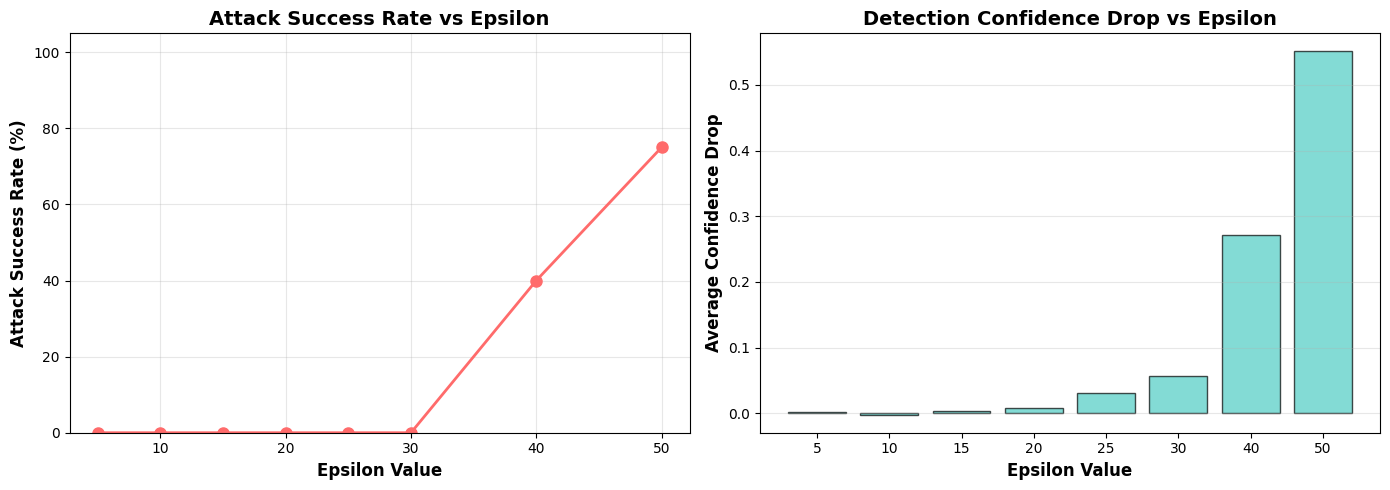


KEY FINDINGS:
• Minimum epsilon for successful attack: 40
• Maximum confidence drop: 0.551
• Epsilon with highest success rate: 50


In [36]:
# Analyze attack effectiveness
print("\n" + "="*70)
print("ATTACK EFFECTIVENESS ANALYSIS")
print("="*70)

# Group by epsilon
epsilon_analysis = {}
for r in attack_results:
    eps = r['epsilon']
    if eps not in epsilon_analysis:
        epsilon_analysis[eps] = {
            'total': 0,
            'successful': 0,
            'avg_conf_drop': 0,
            'conf_drops': []
        }
    epsilon_analysis[eps]['total'] += 1
    if r['attack_success']:
        epsilon_analysis[eps]['successful'] += 1
    epsilon_analysis[eps]['conf_drops'].append(r['conf_drop'])

print(f"\n{'Epsilon':<10} {'Attacks':<10} {'Success':<10} {'Rate':<10} {'Avg Conf Drop':<15}")
print("-" * 55)

for eps in sorted(epsilon_analysis.keys()):
    data = epsilon_analysis[eps]
    success_rate = data['successful'] / data['total'] * 100
    avg_drop = np.mean(data['conf_drops'])
    print(f"{eps:<10} {data['total']:<10} {data['successful']:<10} {success_rate:<9.1f}% {avg_drop:<15.3f}")

# Visualization: Success rate vs Epsilon
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Success rate
epsilons = sorted(epsilon_analysis.keys())
success_rates = [epsilon_analysis[e]['successful'] / epsilon_analysis[e]['total'] * 100 
                 for e in epsilons]

axes[0].plot(epsilons, success_rates, marker='o', linewidth=2, markersize=8, color='#FF6B6B')
axes[0].set_xlabel('Epsilon Value', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Attack Success Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Attack Success Rate vs Epsilon', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0, 105])

# Plot 2: Average confidence drop
avg_drops = [np.mean(epsilon_analysis[e]['conf_drops']) for e in epsilons]

axes[1].bar(range(len(epsilons)), avg_drops, color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(epsilons)))
axes[1].set_xticklabels([str(e) for e in epsilons])
axes[1].set_xlabel('Epsilon Value', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Confidence Drop', fontsize=12, fontweight='bold')
axes[1].set_title('Detection Confidence Drop vs Epsilon', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY FINDINGS:")
print("="*70)
min_successful_eps = min([e for e in epsilons if epsilon_analysis[e]['successful'] > 0], default=None)
if min_successful_eps:
    print(f"• Minimum epsilon for successful attack: {min_successful_eps}")
print(f"• Maximum confidence drop: {max(avg_drops):.3f}")
print(f"• Epsilon with highest success rate: {epsilons[success_rates.index(max(success_rates))]}")
print("="*70)

## ATTACK 2: Targeted Region Transfer

TARGETED REGION TRANSFER: SOURCE <- TARGET (strong blend)
Source bbox: [587, 541, 848, 605] (conf=0.662)
Target bbox: [640, 578, 884, 645] (conf=0.730)
Delta stats before clamp | max: 114.00, mean: 23.63
Applied delta | global max: 92.00, roi mean: 22.72
Final bbox: [587, 540, 850, 602] (conf=0.718) | IoU to target: 0.183


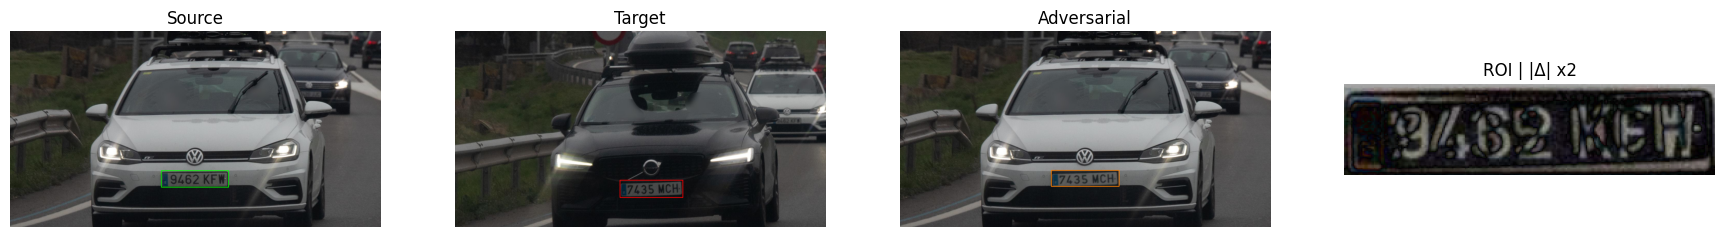

In [37]:
# Targeted region transfer (strong): map target appearance into source bbox with guaranteed delta
print("="*70)
print("TARGETED REGION TRANSFER: SOURCE <- TARGET (strong blend)")
print("="*70)

import numpy as np


def first_bbox(res):
    if res and len(res) > 0 and len(res[0].boxes.data) > 0:
        x1, y1, x2, y2, conf, cls = res[0].boxes.data[0][:6]
        return [int(x1), int(y1), int(x2), int(y2)], float(conf)
    return None, 0.0


def clamp_bbox(bb, h, w):
    x1, y1, x2, y2 = bb
    x1 = int(np.clip(x1, 0, w - 1)); x2 = int(np.clip(x2, 0, w - 1))
    y1 = int(np.clip(y1, 0, h - 1)); y2 = int(np.clip(y2, 0, h - 1))
    if x2 <= x1: x2 = min(w - 1, x1 + 1)
    if y2 <= y1: y2 = min(h - 1, y1 + 1)
    return [x1, y1, x2, y2]


def iou(bb1, bb2):
    x1 = max(bb1[0], bb2[0]); y1 = max(bb1[1], bb2[1])
    x2 = min(bb1[2], bb2[2]); y2 = min(bb1[3], bb2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    a1 = max(0, bb1[2] - bb1[0]) * max(0, bb1[3] - bb1[1])
    a2 = max(0, bb2[2] - bb2[0]) * max(0, bb2[3] - bb2[1])
    union = a1 + a2 - inter
    return inter / union if union > 0 else 0.0


if 'sample_images' in globals() and len(sample_images) >= 2:
    src_rgb = sample_images[0]
    tgt_rgb = sample_images[1]
    H, W = src_rgb.shape[:2]
    src_bgr = cv2.cvtColor(src_rgb, cv2.COLOR_RGB2BGR)
    tgt_bgr = cv2.cvtColor(tgt_rgb, cv2.COLOR_RGB2BGR)

    src_res = model.predict(source=src_bgr, save=False, verbose=False)
    tgt_res = model.predict(source=tgt_bgr, save=False, verbose=False)

    src_bb, src_conf = first_bbox(src_res)
    tgt_bb, tgt_conf = first_bbox(tgt_res)
    if not src_bb or not tgt_bb:
        print("Need both source and target detections available.")
    else:
        src_bb = clamp_bbox(src_bb, H, W)
        tgt_bb = clamp_bbox(tgt_bb, tgt_rgb.shape[0], tgt_rgb.shape[1])
        print(f"Source bbox: {src_bb} (conf={src_conf:.3f})")
        print(f"Target bbox: {tgt_bb} (conf={tgt_conf:.3f})")

        sx1, sy1, sx2, sy2 = src_bb
        tx1, ty1, tx2, ty2 = tgt_bb
        src_roi = src_rgb[sy1:sy2, sx1:sx2]
        tgt_roi = tgt_rgb[ty1:ty2, tx1:tx2]
        if src_roi.size == 0 or tgt_roi.size == 0:
            print("Invalid ROI sizes; cannot transfer.")
        else:
            # Resize target ROI to source ROI size
            tgt_roi_resized = cv2.resize(tgt_roi, (src_roi.shape[1], src_roi.shape[0]))

            # Build overlay and ensure non-zero delta
            overlay = cv2.convertScaleAbs(tgt_roi_resized, alpha=1.15, beta=10)
            delta = overlay.astype(np.float32) - src_roi.astype(np.float32)
            max_abs = float(np.max(np.abs(delta)))
            mean_abs = float(np.mean(np.abs(delta)))
            print(f"Delta stats before clamp | max: {max_abs:.2f}, mean: {mean_abs:.2f}")

            # If still tiny, intensify
            if max_abs < 1.5:
                overlay = cv2.convertScaleAbs(tgt_roi_resized, alpha=1.35, beta=22)
                delta = overlay.astype(np.float32) - src_roi.astype(np.float32)
                max_abs = float(np.max(np.abs(delta)))
                mean_abs = float(np.mean(np.abs(delta)))
                print(f"Amplified overlay | max: {max_abs:.2f}, mean: {mean_abs:.2f}")

            # Clamp by epsilon and apply
            epsilon = 80.0
            delta = np.clip(delta, -epsilon, epsilon)
            adv_roi = (src_roi.astype(np.float32) + delta).clip(0, 255).astype(np.uint8)

            # Mild smoothing to mask seams
            k = max(3, int(0.02 * min(src_roi.shape[:2])) * 2 + 1)
            adv_roi = cv2.GaussianBlur(adv_roi, (k, k), 0)

            adv_rgb = src_rgb.copy()
            adv_rgb[sy1:sy2, sx1:sx2] = adv_roi

            # Report actual applied delta
            applied_delta = adv_rgb.astype(np.float32) - src_rgb.astype(np.float32)
            applied_max = float(np.max(np.abs(applied_delta)))
            applied_mean = float(np.mean(np.abs(applied_delta[sy1:sy2, sx1:sx2])))
            print(f"Applied delta | global max: {applied_max:.2f}, roi mean: {applied_mean:.2f}")

            # Evaluate post-detection
            final_bgr = cv2.cvtColor(adv_rgb, cv2.COLOR_RGB2BGR)
            final_res = model.predict(source=final_bgr, save=False, verbose=False)
            final_bb, final_conf = first_bbox(final_res)
            final_iou = iou(final_bb, tgt_bb) if final_bb else 0.0
            print(f"Final bbox: {final_bb} (conf={final_conf:.3f}) | IoU to target: {final_iou:.3f}")

            # Visuals
            cv2.imwrite("adv_region_transfer_strong.png", cv2.cvtColor(adv_rgb, cv2.COLOR_RGB2BGR))
            vis_src = src_rgb.copy(); vis_tgt = tgt_rgb.copy(); vis_adv = adv_rgb.copy()
            cv2.rectangle(vis_src, (sx1, sy1), (sx2, sy2), (0, 255, 0), 2)
            cv2.rectangle(vis_tgt, (tx1, ty1), (tx2, ty2), (255, 0, 0), 2)
            if final_bb:
                cv2.rectangle(vis_adv, (final_bb[0], final_bb[1]), (final_bb[2], final_bb[3]), (255, 128, 0), 2)
            fig, axes = plt.subplots(1, 4, figsize=(22, 6))
            axes[0].imshow(vis_src); axes[0].set_title('Source'); axes[0].axis('off')
            axes[1].imshow(vis_tgt); axes[1].set_title('Target'); axes[1].axis('off')
            axes[2].imshow(vis_adv); axes[2].set_title('Adversarial'); axes[2].axis('off')
            diff_vis = (np.abs(adv_roi.astype(np.float32) - src_roi.astype(np.float32)) * 2).clip(0, 255).astype(np.uint8)
            axes[3].imshow(diff_vis); axes[3].set_title('ROI | |Δ| x2'); axes[3].axis('off')
            plt.show()
else:
    print("Need at least two sample images loaded. Run dataset load cell.")

In [38]:
# Probe OCR on final adversarial image
print("="*70)
print("OCR PROBE ON FINAL ADVERSARIAL IMAGE")
print("="*70)
ocr_result = ocr.ocr(final_bgr)
# Use the proven helper if available; else parse best text
try:
    cleaned_text, best_conf = extract_license_plate(ocr_result)
except Exception:
    best_text = ""; best_conf = 0.0
    if ocr_result and len(ocr_result) > 0 and isinstance(ocr_result[0], list):
        for det in ocr_result[0]:
            if isinstance(det, (list, tuple)) and len(det) >= 2:
                info = det[1]
                if isinstance(info, (list, tuple)) and len(info) >= 2:
                    txt, cf = info[0], float(info[1])
                    if cf > best_conf and isinstance(txt, str):
                        best_text, best_conf = txt, cf
    cleaned_text = re.sub(r'[^A-Za-z0-9]', '', best_text).upper()
print(f"OCR Text: '{cleaned_text}' (conf={best_conf:.2f})")

OCR PROBE ON FINAL ADVERSARIAL IMAGE
[2025/12/13 18:02:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13394975662231445
[2025/12/13 18:02:04] ppocr DEBUG: cls num  : 1, elapsed : 0.010231971740722656
[2025/12/13 18:02:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07148265838623047
OCR Text: '7435MCH' (conf=0.99)


### Attack 3: IMPERCEPTIBLE OCR ATTACK

SWEEP FGSM PARAMS: EPSILON x STEPS FOR OCR CHANGE
[2025/12/13 18:02:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011240720748901367
[2025/12/13 18:02:05] ppocr DEBUG: cls num  : 1, elapsed : 0.004953145980834961
[2025/12/13 18:02:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05748438835144043
Target image 0 baseline OCR: '9462KFW' (conf=0.98)
[2025/12/13 18:02:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009427309036254883
[2025/12/13 18:02:05] ppocr DEBUG: cls num  : 1, elapsed : 0.004631996154785156
[2025/12/13 18:02:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05838656425476074
[2025/12/13 18:02:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009475946426391602
[2025/12/13 18:02:05] ppocr DEBUG: cls num  : 1, elapsed : 0.004858255386352539
[2025/12/13 18:02:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05832409858703613
[2025/12/13 18:02:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009618997573852539
[2025/12/13 18:02:05] ppocr DEBUG: cls num  : 1, elapsed : 0.0047733783721

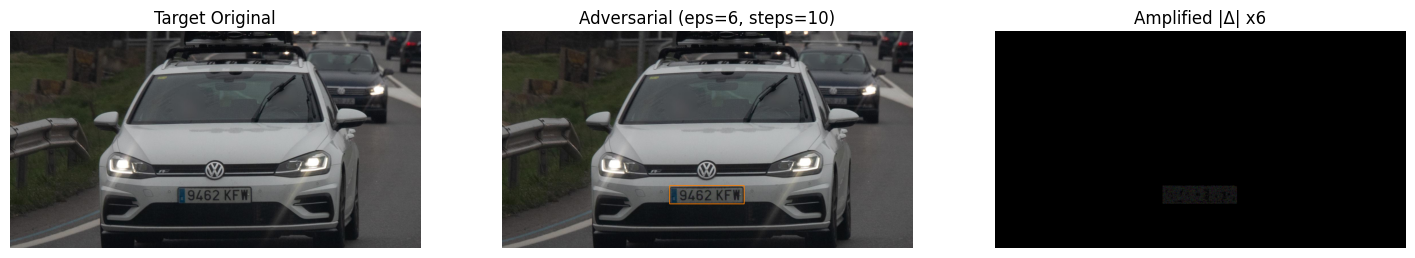

In [39]:
# Sweep FGSM parameters (epsilon, steps) to change OCR on target image
print("="*70)
print("SWEEP FGSM PARAMS: EPSILON x STEPS FOR OCR CHANGE")
print("="*70)

import numpy as np


def first_bbox(res):
    if res and len(res) > 0 and len(res[0].boxes.data) > 0:
        x1, y1, x2, y2, conf, cls = res[0].boxes.data[0][:6]
        return [int(x1), int(y1), int(x2), int(y2)], float(conf)
    return None, 0.0


def clamp_bbox(bb, h, w):
    x1, y1, x2, y2 = bb
    x1 = int(np.clip(x1, 0, w - 1)); x2 = int(np.clip(x2, 0, w - 1))
    y1 = int(np.clip(y1, 0, h - 1)); y2 = int(np.clip(y2, 0, h - 1))
    if x2 <= x1: x2 = min(w - 1, x1 + 1)
    if y2 <= y1: y2 = min(h - 1, y1 + 1)
    return [x1, y1, x2, y2]


def build_edge_mask(roi_rgb, ksize=3, thresh=22):
    gray = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, thresh, thresh*2)
    dil = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (ksize, ksize)))
    mask = (dil > 0).astype(np.float32)
    mask = cv2.GaussianBlur(mask, (ksize*2+1, ksize*2+1), 0)
    return np.expand_dims(np.clip(mask, 0.0, 1.0), axis=2)


def ocr_text_conf(roi_rgb):
    try:
        res = ocr.ocr(cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2BGR))
        txt, conf = extract_license_plate(res)
        return txt, conf
    except Exception:
        return "", 0.0


if 'sample_images' in globals() and len(sample_images) >= 2:
    tgt_idx = 0
    tgt_rgb = sample_images[tgt_idx]
    tgt_bgr = cv2.cvtColor(tgt_rgb, cv2.COLOR_RGB2BGR)
    res = model.predict(source=tgt_bgr, save=False, verbose=False)
    cv2.imwrite("tgt_image.png", cv2.cvtColor(tgt_rgb, cv2.COLOR_RGB2BGR))
    bb, det_conf = first_bbox(res)
    if not bb:
        print("No plate detected on target image; choose another.")
    else:
        x1, y1, x2, y2 = clamp_bbox(bb, tgt_rgb.shape[0], tgt_rgb.shape[1])
        roi = tgt_rgb[y1:y2, x1:x2]
        if roi.size == 0:
            print("Empty ROI; abort.")
        else:
            base_text, base_conf = ocr_text_conf(roi)
            print(f"Target image {tgt_idx} baseline OCR: '{base_text}' (conf={base_conf:.2f})")

            mask = build_edge_mask(roi, ksize=2, thresh=24)
            epsilon_list = [4, 6, 8, 10, 12]
            steps_list = [6, 8, 10, 12]
            sigma = 1.5

            best = None  # (epsilon, steps, adv_img, new_text, new_conf)
            for eps in epsilon_list:
                for steps in steps_list:
                    adv = roi.copy().astype(np.float32)
                    changed = False
                    for k in range(steps):
                        # Direction via finite difference (reduce current conf)
                        z = np.random.normal(0.0, 1.0, roi.shape).astype(np.float32)
                        z = cv2.GaussianBlur(z, (3,3), 0) * mask
                        plus = np.clip(adv + sigma * z, 0, 255).astype(np.uint8)
                        minus = np.clip(adv - sigma * z, 0, 255).astype(np.uint8)
                        _, c_plus = ocr_text_conf(plus)
                        _, c_minus = ocr_text_conf(minus)
                        direction = 1.0 if c_plus < c_minus else -1.0

                        adv = adv + direction * eps * np.sign(z)
                        delta = np.clip(adv - roi.astype(np.float32), -eps, eps)
                        adv = np.clip(roi.astype(np.float32) + delta, 0, 255)
                        adv_uint = adv.astype(np.uint8)
                        adv_uint = cv2.bilateralFilter(adv_uint, d=5, sigmaColor=8, sigmaSpace=8)
                        adv = adv_uint.astype(np.float32)

                        cur_text, cur_conf = ocr_text_conf(adv_uint)
                        print(f"eps={eps:2d}, steps={steps:2d} | step {k+1}/{steps} | text='{cur_text}' (conf={cur_conf:.2f})")
                        if cur_text and base_text and cur_text != base_text:
                            changed = True
                            break

                    adv_img = tgt_rgb.copy()
                    adv_img[y1:y2, x1:x2] = adv.astype(np.uint8)

                    if changed:
                        best = (eps, steps, adv_img, cur_text, cur_conf)
                        break
                if best is not None:
                    break

            if best is not None:
                eps_found, steps_found, adv_img_best, new_text, new_conf = best
                print(f"\n✅ Found change with eps={eps_found}, steps={steps_found}: '{base_text}' -> '{new_text}' (conf={new_conf:.2f})")
                cv2.imwrite("adv_fgsm_sweep.png", cv2.cvtColor(adv_img_best, cv2.COLOR_RGB2BGR))
                fig, axes = plt.subplots(1,3, figsize=(18,6))
                axes[0].imshow(tgt_rgb); axes[0].set_title('Target Original'); axes[0].axis('off')
                vis_adv = adv_img_best.copy(); cv2.rectangle(vis_adv, (x1,y1), (x2,y2), (255,128,0), 2)
                axes[1].imshow(vis_adv); axes[1].set_title(f'Adversarial (eps={eps_found}, steps={steps_found})'); axes[1].axis('off')
                diff = (np.abs(adv_img_best.astype(np.float32)-tgt_rgb.astype(np.float32))*6).clip(0,255).astype(np.uint8)
                axes[2].imshow(diff); axes[2].set_title('Amplified |Δ| x6'); axes[2].axis('off')
                plt.show()
            else:
                print("\n❌ No configuration achieved OCR change. Consider expanding epsilon/steps or multiple direction probes per step.")
else:
    print("Not enough sample images; run dataset cell first.")